In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(317441, 828)
(317441, 1)
validation
(36648, 828)
(36648, 1)
test
(43097, 828)
(43097, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/32 [..............................] - ETA: 35s - loss: 0.1079 - STD: 1.8154e-04 - MAE: 0.3140

 4/32 [==>...........................] - ETA: 0s - loss: 0.0382 - STD: 2.7784e-04 - MAE: 0.1500 

 5/32 [===>..........................] - ETA: 0s - loss: 0.0350 - STD: 2.5235e-04 - MAE: 0.1433

 6/32 [====>.........................] - ETA: 1s - loss: 0.0334 - STD: 2.2811e-04 - MAE: 0.1406

 7/32 [=====>........................] - ETA: 1s - loss: 0.0323 - STD: 2.0665e-04 - MAE: 0.1389

 8/32 [======>.......................] - ETA: 1s - loss: 0.0316 - STD: 1.8841e-04 - MAE: 0.1382

 9/32 [=======>......................] - ETA: 1s - loss: 0.0311 - STD: 1.7284e-04 - MAE: 0.1376

10/32 [========>.....................] - ETA: 1s - loss: 0.0305 - STD: 1.5950e-04 - MAE: 0.1367

11/32 [=========>....................] - ETA: 1s - loss: 0.0300 - STD: 1.4792e-04 - MAE: 0.1358

12/32 [==========>...................] - ETA: 1s - loss: 0.0295 - STD: 1.3793e-04 - MAE: 0.1346

13/32 [===========>..................] - ETA: 1s - loss: 0.0289 - STD: 1.2929e-04 - MAE: 0.1332

14/32 [============>.................] - ETA: 0s - loss: 0.0283 - STD: 1.2191e-04 - MAE: 0.1314

15/32 [=============>................] - ETA: 0s - loss: 0.0277 - STD: 1.1568e-04 - MAE: 0.1295

16/32 [==============>...............] - ETA: 0s - loss: 0.0269 - STD: 1.1049e-04 - MAE: 0.1272

17/32 [==============>...............] - ETA: 0s - loss: 0.0262 - STD: 1.0623e-04 - MAE: 0.1248

18/32 [===============>..............] - ETA: 0s - loss: 0.0254 - STD: 1.0274e-04 - MAE: 0.1222

19/32 [================>.............] - ETA: 0s - loss: 0.0246 - STD: 9.9866e-05 - MAE: 0.1199

20/32 [=================>............] - ETA: 0s - loss: 0.0239 - STD: 9.7456e-05 - MAE: 0.1176

21/32 [==================>...........] - ETA: 0s - loss: 0.0232 - STD: 9.5390e-05 - MAE: 0.1157

22/32 [===================>..........] - ETA: 0s - loss: 0.0226 - STD: 9.3593e-05 - MAE: 0.1142

23/32 [====================>.........] - ETA: 0s - loss: 0.0221 - STD: 9.1968e-05 - MAE: 0.1130

24/32 [=====================>........] - ETA: 0s - loss: 0.0217 - STD: 9.0456e-05 - MAE: 0.1121

25/32 [======================>.......] - ETA: 0s - loss: 0.0213 - STD: 8.8997e-05 - MAE: 0.1114

26/32 [=======================>......] - ETA: 0s - loss: 0.0210 - STD: 8.7607e-05 - MAE: 0.1108

27/32 [========================>.....] - ETA: 0s - loss: 0.0206 - STD: 8.6265e-05 - MAE: 0.1101

28/32 [=========================>....] - ETA: 0s - loss: 0.0203 - STD: 8.4964e-05 - MAE: 0.1094

29/32 [==========================>...] - ETA: 0s - loss: 0.0199 - STD: 8.3730e-05 - MAE: 0.1085

30/32 [===========================>..] - ETA: 0s - loss: 0.0196 - STD: 8.2553e-05 - MAE: 0.1076

31/32 [============================>.] - ETA: 0s - loss: 0.0194 - STD: 8.1407e-05 - MAE: 0.1067

32/32 [==============================] - 4s 95ms/step - loss: 0.0190 - STD: 8.0311e-05 - MAE: 0.1057 - val_loss: 0.0096 - val_STD: 4.2986e-05 - val_MAE: 0.0763


Epoch 2/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0097 - STD: 4.5564e-05 - MAE: 0.0758

 2/32 [>.............................] - ETA: 1s - loss: 0.0098 - STD: 4.5436e-05 - MAE: 0.0753

 3/32 [=>............................] - ETA: 1s - loss: 0.0098 - STD: 4.5459e-05 - MAE: 0.0749

 4/32 [==>...........................] - ETA: 1s - loss: 0.0099 - STD: 4.5371e-05 - MAE: 0.0750

 5/32 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 4.5405e-05 - MAE: 0.0749

 6/32 [====>.........................] - ETA: 1s - loss: 0.0101 - STD: 4.5501e-05 - MAE: 0.0751

 7/32 [=====>........................] - ETA: 1s - loss: 0.0101 - STD: 4.5686e-05 - MAE: 0.0750

 8/32 [======>.......................] - ETA: 1s - loss: 0.0101 - STD: 4.6174e-05 - MAE: 0.0749

 9/32 [=======>......................] - ETA: 1s - loss: 0.0101 - STD: 4.6516e-05 - MAE: 0.0749

10/32 [========>.....................] - ETA: 1s - loss: 0.0101 - STD: 4.6940e-05 - MAE: 0.0749

11/32 [=========>....................] - ETA: 1s - loss: 0.0100 - STD: 4.7461e-05 - MAE: 0.0750

12/32 [==========>...................] - ETA: 1s - loss: 0.0100 - STD: 4.8240e-05 - MAE: 0.0750

13/32 [===========>..................] - ETA: 1s - loss: 0.0100 - STD: 4.8877e-05 - MAE: 0.0751

14/32 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 4.9578e-05 - MAE: 0.0752

15/32 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 5.0280e-05 - MAE: 0.0754

16/32 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 5.1018e-05 - MAE: 0.0756

17/32 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 5.1850e-05 - MAE: 0.0759

18/32 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 5.2631e-05 - MAE: 0.0760

19/32 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 5.3400e-05 - MAE: 0.0763

20/32 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 5.4138e-05 - MAE: 0.0764

21/32 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 5.4847e-05 - MAE: 0.0766

22/32 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 5.5558e-05 - MAE: 0.0766

23/32 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 5.6219e-05 - MAE: 0.0766

24/32 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 5.6863e-05 - MAE: 0.0767

25/32 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 5.7443e-05 - MAE: 0.0766

26/32 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 5.7970e-05 - MAE: 0.0766

28/32 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 5.9013e-05 - MAE: 0.0765

29/32 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 5.9557e-05 - MAE: 0.0765

30/32 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 6.0132e-05 - MAE: 0.0764

31/32 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 6.0703e-05 - MAE: 0.0764

32/32 [==============================] - ETA: 0s - loss: 0.0097 - STD: 6.1287e-05 - MAE: 0.0763

32/32 [==============================] - 2s 64ms/step - loss: 0.0097 - STD: 6.1287e-05 - MAE: 0.0763 - val_loss: 0.0096 - val_STD: 7.6904e-05 - val_MAE: 0.0765


Epoch 3/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0096 - STD: 8.1960e-05 - MAE: 0.0758

 2/32 [>.............................] - ETA: 2s - loss: 0.0096 - STD: 8.2838e-05 - MAE: 0.0755

 3/32 [=>............................] - ETA: 1s - loss: 0.0096 - STD: 8.3524e-05 - MAE: 0.0756

 4/32 [==>...........................] - ETA: 1s - loss: 0.0095 - STD: 8.4533e-05 - MAE: 0.0755

 5/32 [===>..........................] - ETA: 1s - loss: 0.0095 - STD: 8.5745e-05 - MAE: 0.0757

 6/32 [====>.........................] - ETA: 1s - loss: 0.0095 - STD: 8.7045e-05 - MAE: 0.0759

 8/32 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 8.9845e-05 - MAE: 0.0762

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 9.1201e-05 - MAE: 0.0763

10/32 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 9.2520e-05 - MAE: 0.0764

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 9.3666e-05 - MAE: 0.0765

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 9.4775e-05 - MAE: 0.0765

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 9.5826e-05 - MAE: 0.0765

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 9.6797e-05 - MAE: 0.0765

15/32 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 9.7680e-05 - MAE: 0.0765

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 9.8655e-05 - MAE: 0.0766

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 9.9590e-05 - MAE: 0.0766

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 1.0058e-04 - MAE: 0.0766

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 1.0152e-04 - MAE: 0.0766

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 1.0247e-04 - MAE: 0.0766

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 1.0347e-04 - MAE: 0.0765

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 1.0455e-04 - MAE: 0.0765

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 1.0564e-04 - MAE: 0.0765

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 1.0682e-04 - MAE: 0.0765

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 1.0796e-04 - MAE: 0.0765

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 1.0912e-04 - MAE: 0.0765

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 1.1039e-04 - MAE: 0.0764

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 1.1165e-04 - MAE: 0.0764

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 1.1297e-04 - MAE: 0.0764

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 1.1432e-04 - MAE: 0.0764

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 1.1570e-04 - MAE: 0.0764

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 1.1712e-04 - MAE: 0.0764

32/32 [==============================] - 2s 66ms/step - loss: 0.0095 - STD: 1.1712e-04 - MAE: 0.0764 - val_loss: 0.0095 - val_STD: 1.5515e-04 - val_MAE: 0.0774


Epoch 4/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0096 - STD: 1.6316e-04 - MAE: 0.0771

 2/32 [>.............................] - ETA: 1s - loss: 0.0096 - STD: 1.6497e-04 - MAE: 0.0768

 3/32 [=>............................] - ETA: 1s - loss: 0.0096 - STD: 1.6727e-04 - MAE: 0.0769

 4/32 [==>...........................] - ETA: 1s - loss: 0.0096 - STD: 1.6940e-04 - MAE: 0.0770

 5/32 [===>..........................] - ETA: 1s - loss: 0.0096 - STD: 1.7124e-04 - MAE: 0.0769

 6/32 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 1.7362e-04 - MAE: 0.0768

 7/32 [=====>........................] - ETA: 1s - loss: 0.0095 - STD: 1.7565e-04 - MAE: 0.0767

 8/32 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 1.7762e-04 - MAE: 0.0766

 9/32 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 1.7971e-04 - MAE: 0.0765

10/32 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 1.8180e-04 - MAE: 0.0765

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 1.8383e-04 - MAE: 0.0764

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 1.8593e-04 - MAE: 0.0763

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 1.8792e-04 - MAE: 0.0763

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 1.9019e-04 - MAE: 0.0763

15/32 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 1.9237e-04 - MAE: 0.0764

16/32 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 1.9467e-04 - MAE: 0.0763

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 1.9706e-04 - MAE: 0.0764

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 1.9967e-04 - MAE: 0.0764

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 2.0235e-04 - MAE: 0.0764

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 2.0521e-04 - MAE: 0.0764

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 2.0814e-04 - MAE: 0.0764

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 2.1103e-04 - MAE: 0.0764

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 2.1390e-04 - MAE: 0.0764

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 2.1696e-04 - MAE: 0.0764

25/32 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 2.1988e-04 - MAE: 0.0764

26/32 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 2.2298e-04 - MAE: 0.0764

27/32 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 2.2601e-04 - MAE: 0.0764

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 2.2923e-04 - MAE: 0.0764

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 2.3253e-04 - MAE: 0.0763

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 2.3601e-04 - MAE: 0.0763

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 2.3941e-04 - MAE: 0.0764

32/32 [==============================] - 2s 66ms/step - loss: 0.0095 - STD: 2.4295e-04 - MAE: 0.0764 - val_loss: 0.0095 - val_STD: 3.4236e-04 - val_MAE: 0.0770


Epoch 5/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0093 - STD: 3.5904e-04 - MAE: 0.0751

 3/32 [=>............................] - ETA: 1s - loss: 0.0095 - STD: 3.7264e-04 - MAE: 0.0763

 4/32 [==>...........................] - ETA: 1s - loss: 0.0095 - STD: 3.7870e-04 - MAE: 0.0764

 5/32 [===>..........................] - ETA: 1s - loss: 0.0096 - STD: 3.8443e-04 - MAE: 0.0765

 6/32 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 3.9088e-04 - MAE: 0.0765

 7/32 [=====>........................] - ETA: 1s - loss: 0.0096 - STD: 3.9755e-04 - MAE: 0.0765

 8/32 [======>.......................] - ETA: 1s - loss: 0.0096 - STD: 4.0402e-04 - MAE: 0.0766

 9/32 [=======>......................] - ETA: 1s - loss: 0.0096 - STD: 4.1068e-04 - MAE: 0.0766

10/32 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 4.1758e-04 - MAE: 0.0766

11/32 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 4.2460e-04 - MAE: 0.0765

12/32 [==========>...................] - ETA: 1s - loss: 0.0095 - STD: 4.3144e-04 - MAE: 0.0765

13/32 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 4.3863e-04 - MAE: 0.0765

14/32 [============>.................] - ETA: 1s - loss: 0.0095 - STD: 4.4582e-04 - MAE: 0.0765

15/32 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 4.5331e-04 - MAE: 0.0764

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 4.6071e-04 - MAE: 0.0764

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 4.6855e-04 - MAE: 0.0764

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 4.7695e-04 - MAE: 0.0763

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 4.8534e-04 - MAE: 0.0763

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 4.9407e-04 - MAE: 0.0763

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 5.0302e-04 - MAE: 0.0763

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 5.1252e-04 - MAE: 0.0763

23/32 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 5.2211e-04 - MAE: 0.0762

24/32 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 5.3223e-04 - MAE: 0.0762

25/32 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 5.4317e-04 - MAE: 0.0762

26/32 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 5.5429e-04 - MAE: 0.0762

27/32 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 5.6563e-04 - MAE: 0.0762

28/32 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 5.7743e-04 - MAE: 0.0762

29/32 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 5.8950e-04 - MAE: 0.0762

30/32 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 6.0240e-04 - MAE: 0.0763

31/32 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 6.1553e-04 - MAE: 0.0763

32/32 [==============================] - ETA: 0s - loss: 0.0095 - STD: 6.2889e-04 - MAE: 0.0763

32/32 [==============================] - 2s 65ms/step - loss: 0.0095 - STD: 6.2889e-04 - MAE: 0.0763 - val_loss: 0.0094 - val_STD: 0.0010 - val_MAE: 0.0769


Epoch 6/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0095 - STD: 0.0011 - MAE: 0.0765

 2/32 [>.............................] - ETA: 1s - loss: 0.0092 - STD: 0.0011 - MAE: 0.0757

 3/32 [=>............................] - ETA: 1s - loss: 0.0092 - STD: 0.0011 - MAE: 0.0756

 4/32 [==>...........................] - ETA: 1s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0759

 5/32 [===>..........................] - ETA: 1s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0758

 6/32 [====>.........................] - ETA: 1s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0759

 7/32 [=====>........................] - ETA: 1s - loss: 0.0094 - STD: 0.0012 - MAE: 0.0760

 8/32 [======>.......................] - ETA: 1s - loss: 0.0094 - STD: 0.0013 - MAE: 0.0761

 9/32 [=======>......................] - ETA: 1s - loss: 0.0094 - STD: 0.0013 - MAE: 0.0762

10/32 [========>.....................] - ETA: 1s - loss: 0.0094 - STD: 0.0013 - MAE: 0.0762

11/32 [=========>....................] - ETA: 1s - loss: 0.0094 - STD: 0.0014 - MAE: 0.0762

12/32 [==========>...................] - ETA: 1s - loss: 0.0094 - STD: 0.0014 - MAE: 0.0761

13/32 [===========>..................] - ETA: 1s - loss: 0.0094 - STD: 0.0014 - MAE: 0.0761

14/32 [============>.................] - ETA: 1s - loss: 0.0094 - STD: 0.0015 - MAE: 0.0762

15/32 [=============>................] - ETA: 1s - loss: 0.0094 - STD: 0.0015 - MAE: 0.0762

16/32 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 0.0015 - MAE: 0.0761

17/32 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 0.0016 - MAE: 0.0761

18/32 [===============>..............] - ETA: 0s - loss: 0.0094 - STD: 0.0016 - MAE: 0.0761

19/32 [================>.............] - ETA: 0s - loss: 0.0094 - STD: 0.0017 - MAE: 0.0760

20/32 [=================>............] - ETA: 0s - loss: 0.0094 - STD: 0.0017 - MAE: 0.0760

21/32 [==================>...........] - ETA: 0s - loss: 0.0094 - STD: 0.0018 - MAE: 0.0760

23/32 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0019 - MAE: 0.0759

24/32 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0019 - MAE: 0.0759

25/32 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0020 - MAE: 0.0759

26/32 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0021 - MAE: 0.0759

27/32 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0021 - MAE: 0.0758

28/32 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0022 - MAE: 0.0758

29/32 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0023 - MAE: 0.0757

30/32 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0023 - MAE: 0.0757

31/32 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0024 - MAE: 0.0757

32/32 [==============================] - ETA: 0s - loss: 0.0093 - STD: 0.0025 - MAE: 0.0757

32/32 [==============================] - 2s 66ms/step - loss: 0.0093 - STD: 0.0025 - MAE: 0.0757 - val_loss: 0.0090 - val_STD: 0.0051 - val_MAE: 0.0754


Epoch 7/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0092 - STD: 0.0054 - MAE: 0.0749

 2/32 [>.............................] - ETA: 1s - loss: 0.0091 - STD: 0.0056 - MAE: 0.0747

 3/32 [=>............................] - ETA: 1s - loss: 0.0090 - STD: 0.0057 - MAE: 0.0744

 4/32 [==>...........................] - ETA: 1s - loss: 0.0090 - STD: 0.0059 - MAE: 0.0744

 5/32 [===>..........................] - ETA: 1s - loss: 0.0090 - STD: 0.0061 - MAE: 0.0745

 6/32 [====>.........................] - ETA: 1s - loss: 0.0090 - STD: 0.0063 - MAE: 0.0744

 7/32 [=====>........................] - ETA: 1s - loss: 0.0090 - STD: 0.0065 - MAE: 0.0745

 8/32 [======>.......................] - ETA: 1s - loss: 0.0090 - STD: 0.0067 - MAE: 0.0745

 9/32 [=======>......................] - ETA: 1s - loss: 0.0090 - STD: 0.0069 - MAE: 0.0746

10/32 [========>.....................] - ETA: 1s - loss: 0.0090 - STD: 0.0071 - MAE: 0.0746

11/32 [=========>....................] - ETA: 1s - loss: 0.0090 - STD: 0.0073 - MAE: 0.0745

12/32 [==========>...................] - ETA: 1s - loss: 0.0090 - STD: 0.0076 - MAE: 0.0745

13/32 [===========>..................] - ETA: 1s - loss: 0.0089 - STD: 0.0078 - MAE: 0.0743

15/32 [=============>................] - ETA: 1s - loss: 0.0089 - STD: 0.0084 - MAE: 0.0742

16/32 [==============>...............] - ETA: 0s - loss: 0.0089 - STD: 0.0086 - MAE: 0.0741

17/32 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0089 - MAE: 0.0740

18/32 [===============>..............] - ETA: 0s - loss: 0.0088 - STD: 0.0092 - MAE: 0.0739

19/32 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.0095 - MAE: 0.0738

20/32 [=================>............] - ETA: 0s - loss: 0.0088 - STD: 0.0099 - MAE: 0.0736

21/32 [==================>...........] - ETA: 0s - loss: 0.0087 - STD: 0.0102 - MAE: 0.0735

22/32 [===================>..........] - ETA: 0s - loss: 0.0087 - STD: 0.0105 - MAE: 0.0735

23/32 [====================>.........] - ETA: 0s - loss: 0.0087 - STD: 0.0109 - MAE: 0.0734

24/32 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0112 - MAE: 0.0733

25/32 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 0.0116 - MAE: 0.0732

26/32 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0120 - MAE: 0.0731

27/32 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0123 - MAE: 0.0730

28/32 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0127 - MAE: 0.0729

29/32 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0131 - MAE: 0.0728

30/32 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0135 - MAE: 0.0727

31/32 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0139 - MAE: 0.0726

32/32 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.0143 - MAE: 0.0725

32/32 [==============================] - 2s 67ms/step - loss: 0.0085 - STD: 0.0143 - MAE: 0.0725 - val_loss: 0.0074 - val_STD: 0.0257 - val_MAE: 0.0688


Epoch 8/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0075 - STD: 0.0280 - MAE: 0.0687

 2/32 [>.............................] - ETA: 1s - loss: 0.0076 - STD: 0.0285 - MAE: 0.0688

 3/32 [=>............................] - ETA: 1s - loss: 0.0076 - STD: 0.0290 - MAE: 0.0689

 4/32 [==>...........................] - ETA: 1s - loss: 0.0076 - STD: 0.0295 - MAE: 0.0686

 5/32 [===>..........................] - ETA: 1s - loss: 0.0076 - STD: 0.0299 - MAE: 0.0685

 6/32 [====>.........................] - ETA: 1s - loss: 0.0075 - STD: 0.0303 - MAE: 0.0683

 7/32 [=====>........................] - ETA: 1s - loss: 0.0076 - STD: 0.0307 - MAE: 0.0684

 8/32 [======>.......................] - ETA: 1s - loss: 0.0076 - STD: 0.0311 - MAE: 0.0683

 9/32 [=======>......................] - ETA: 1s - loss: 0.0076 - STD: 0.0315 - MAE: 0.0682

11/32 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.0323 - MAE: 0.0681

12/32 [==========>...................] - ETA: 1s - loss: 0.0075 - STD: 0.0326 - MAE: 0.0680

13/32 [===========>..................] - ETA: 1s - loss: 0.0075 - STD: 0.0330 - MAE: 0.0679

14/32 [============>.................] - ETA: 1s - loss: 0.0075 - STD: 0.0333 - MAE: 0.0678

15/32 [=============>................] - ETA: 1s - loss: 0.0075 - STD: 0.0337 - MAE: 0.0677

16/32 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0340 - MAE: 0.0676

17/32 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0343 - MAE: 0.0675

18/32 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.0345 - MAE: 0.0674

19/32 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0348 - MAE: 0.0673

20/32 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.0350 - MAE: 0.0672

21/32 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0353 - MAE: 0.0671

22/32 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0355 - MAE: 0.0670

23/32 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0358 - MAE: 0.0669

24/32 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0360 - MAE: 0.0669

25/32 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0363 - MAE: 0.0668

26/32 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0365 - MAE: 0.0667

27/32 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0368 - MAE: 0.0666

28/32 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0371 - MAE: 0.0666

29/32 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0373 - MAE: 0.0665

30/32 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0376 - MAE: 0.0664

31/32 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0378 - MAE: 0.0663

32/32 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0381 - MAE: 0.0662

32/32 [==============================] - 2s 66ms/step - loss: 0.0073 - STD: 0.0381 - MAE: 0.0662 - val_loss: 0.0062 - val_STD: 0.0421 - val_MAE: 0.0620


Epoch 9/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0068 - STD: 0.0459 - MAE: 0.0631

 2/32 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.0460 - MAE: 0.0632

 3/32 [=>............................] - ETA: 1s - loss: 0.0067 - STD: 0.0463 - MAE: 0.0630

 4/32 [==>...........................] - ETA: 1s - loss: 0.0067 - STD: 0.0464 - MAE: 0.0631

 5/32 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0466 - MAE: 0.0632

 6/32 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0466 - MAE: 0.0629

 7/32 [=====>........................] - ETA: 1s - loss: 0.0067 - STD: 0.0467 - MAE: 0.0628

 8/32 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.0468 - MAE: 0.0628

 9/32 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0470 - MAE: 0.0626

11/32 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0473 - MAE: 0.0625

12/32 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0474 - MAE: 0.0623

13/32 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0476 - MAE: 0.0622

14/32 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0479 - MAE: 0.0621

15/32 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0481 - MAE: 0.0620

16/32 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0482 - MAE: 0.0619

17/32 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0484 - MAE: 0.0618

18/32 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0488 - MAE: 0.0617

19/32 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0489 - MAE: 0.0616

20/32 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0491 - MAE: 0.0615

21/32 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0494 - MAE: 0.0615

22/32 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0497 - MAE: 0.0613

23/32 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0498 - MAE: 0.0612

24/32 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0500 - MAE: 0.0611

25/32 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0503 - MAE: 0.0611

26/32 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0505 - MAE: 0.0610

27/32 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0506 - MAE: 0.0609

28/32 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0508 - MAE: 0.0608

29/32 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0509 - MAE: 0.0607

30/32 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0510 - MAE: 0.0606

31/32 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0512 - MAE: 0.0605

32/32 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0514 - MAE: 0.0605

32/32 [==============================] - 2s 65ms/step - loss: 0.0062 - STD: 0.0514 - MAE: 0.0605 - val_loss: 0.0051 - val_STD: 0.0536 - val_MAE: 0.0552


Epoch 10/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0556 - MAE: 0.0582

 2/32 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0570

 3/32 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0553 - MAE: 0.0572

 4/32 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0559 - MAE: 0.0576

 5/32 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0557 - MAE: 0.0575

 6/32 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0558 - MAE: 0.0573

 7/32 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0560 - MAE: 0.0574

 8/32 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0561 - MAE: 0.0573

 9/32 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0563 - MAE: 0.0572

11/32 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0566 - MAE: 0.0570

12/32 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0568 - MAE: 0.0570

13/32 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0570 - MAE: 0.0569

14/32 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0571 - MAE: 0.0568

15/32 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0573 - MAE: 0.0568

16/32 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0574 - MAE: 0.0567

17/32 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0576 - MAE: 0.0567

18/32 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0578 - MAE: 0.0567

19/32 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0580 - MAE: 0.0566

20/32 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0581 - MAE: 0.0566

21/32 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0583 - MAE: 0.0566

22/32 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0584 - MAE: 0.0566

23/32 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0586 - MAE: 0.0566

24/32 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0587 - MAE: 0.0566

25/32 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0587 - MAE: 0.0566

26/32 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0566

27/32 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0589 - MAE: 0.0566

28/32 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0566

29/32 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0566

30/32 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0565

31/32 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0565

32/32 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0592 - MAE: 0.0565

32/32 [==============================] - 2s 66ms/step - loss: 0.0055 - STD: 0.0592 - MAE: 0.0565 - val_loss: 0.0048 - val_STD: 0.0569 - val_MAE: 0.0534


Epoch 11/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0560

 2/32 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0554

 3/32 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0602 - MAE: 0.0556

 4/32 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0605 - MAE: 0.0555

 5/32 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0605 - MAE: 0.0553

 6/32 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0554

 7/32 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0554

 8/32 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0554

 9/32 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0555

10/32 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0554

11/32 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0554

12/32 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0554

13/32 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0554

14/32 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0553

15/32 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0553

16/32 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0553

17/32 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0553

18/32 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0554

19/32 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0554

20/32 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0553

21/32 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0553

22/32 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0553

23/32 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0553

24/32 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0553

25/32 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0553

26/32 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0553

27/32 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0553

28/32 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0553

29/32 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0553

31/32 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0552

32/32 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0552

32/32 [==============================] - 2s 64ms/step - loss: 0.0053 - STD: 0.0618 - MAE: 0.0552 - val_loss: 0.0047 - val_STD: 0.0580 - val_MAE: 0.0523


Epoch 12/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0541

 2/32 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0548

 3/32 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0550

 4/32 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0547

 5/32 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0545

 6/32 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0547

 7/32 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0545

 8/32 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0545

 9/32 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0548

10/32 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0548

11/32 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0547

12/32 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0548

13/32 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0548

14/32 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0548

15/32 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

16/32 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0548

17/32 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0548

18/32 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0549

19/32 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0549

20/32 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0549

21/32 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0550

22/32 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0549

23/32 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0548

24/32 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0549

26/32 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0548

27/32 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0549

28/32 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0548

29/32 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0548

30/32 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

31/32 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0547

32/32 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0547

32/32 [==============================] - 2s 66ms/step - loss: 0.0052 - STD: 0.0628 - MAE: 0.0547 - val_loss: 0.0045 - val_STD: 0.0623 - val_MAE: 0.0522


Epoch 13/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0544

 2/32 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0542

 3/32 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0541

 4/32 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0541

 5/32 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0543

 6/32 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0543

 8/32 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0542

 9/32 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0542

10/32 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0542

11/32 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0542

12/32 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0543

13/32 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

14/32 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

15/32 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0541

16/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0541

17/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0540

18/32 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0540

19/32 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0540

20/32 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0540

21/32 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0539

22/32 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0539

23/32 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0539

24/32 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0539

25/32 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0539

26/32 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0539

27/32 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0539

28/32 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0642 - MAE: 0.0539

29/32 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0642 - MAE: 0.0538

30/32 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0538

31/32 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0538

32/32 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0538

32/32 [==============================] - 2s 64ms/step - loss: 0.0051 - STD: 0.0644 - MAE: 0.0538 - val_loss: 0.0044 - val_STD: 0.0631 - val_MAE: 0.0513


Epoch 14/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0653 - MAE: 0.0526

 2/32 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0649 - MAE: 0.0528

 3/32 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0530

 4/32 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0654 - MAE: 0.0529

 5/32 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0528

 6/32 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0651 - MAE: 0.0530

 7/32 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0531

 8/32 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0532

 9/32 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0531

10/32 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0532

11/32 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0531

12/32 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0532

13/32 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0532

14/32 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0532

15/32 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0532

16/32 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0533

17/32 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0532

18/32 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0533

19/32 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0533

20/32 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0655 - MAE: 0.0534

21/32 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0533

22/32 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0534

23/32 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0534

24/32 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0533

25/32 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0534

26/32 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0534

27/32 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0533

28/32 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0534

29/32 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0534

30/32 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0534

31/32 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0534

32/32 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0534

32/32 [==============================] - 2s 67ms/step - loss: 0.0050 - STD: 0.0649 - MAE: 0.0534 - val_loss: 0.0044 - val_STD: 0.0658 - val_MAE: 0.0523


Epoch 15/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0534

 2/32 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0535

 3/32 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0532

 4/32 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0532

 5/32 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0663 - MAE: 0.0530

 6/32 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0529

 7/32 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0530

 8/32 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0662 - MAE: 0.0530

 9/32 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0531

10/32 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0663 - MAE: 0.0532

11/32 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0531

12/32 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0530

13/32 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0530

14/32 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0530

15/32 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0530

16/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0530

17/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0529

18/32 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0662 - MAE: 0.0530

19/32 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0659 - MAE: 0.0529

20/32 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0529

21/32 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0530

22/32 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0658 - MAE: 0.0529

23/32 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0659 - MAE: 0.0530

24/32 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0530

25/32 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0658 - MAE: 0.0530

26/32 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0659 - MAE: 0.0531

27/32 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0659 - MAE: 0.0531

28/32 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0531

29/32 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0531

30/32 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0658 - MAE: 0.0531

31/32 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0531

32/32 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0531

32/32 [==============================] - 2s 65ms/step - loss: 0.0049 - STD: 0.0657 - MAE: 0.0531 - val_loss: 0.0046 - val_STD: 0.0675 - val_MAE: 0.0534


Epoch 16/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0551

 2/32 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0649 - MAE: 0.0537

 3/32 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0532

 4/32 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0537

 5/32 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0534

 6/32 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0533

 7/32 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0539

 8/32 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0536

 9/32 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0647 - MAE: 0.0535

10/32 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0540

11/32 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0649 - MAE: 0.0538

12/32 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0536

13/32 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0647 - MAE: 0.0538

14/32 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0649 - MAE: 0.0537

15/32 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0536

16/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0536

18/32 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0536

19/32 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0647 - MAE: 0.0535

20/32 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0535

21/32 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0534

22/32 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0651 - MAE: 0.0533

23/32 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0533

24/32 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0532

25/32 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0532

26/32 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0655 - MAE: 0.0531

27/32 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0531

28/32 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0656 - MAE: 0.0530

29/32 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0656 - MAE: 0.0530

30/32 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0530

31/32 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0530

32/32 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0658 - MAE: 0.0529

32/32 [==============================] - 2s 64ms/step - loss: 0.0049 - STD: 0.0658 - MAE: 0.0529 - val_loss: 0.0043 - val_STD: 0.0649 - val_MAE: 0.0504


Epoch 17/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0524

 2/32 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0522

 3/32 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0519

 4/32 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0518

 5/32 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0679 - MAE: 0.0519

 6/32 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0679 - MAE: 0.0518

 7/32 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0517

 8/32 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0519

 9/32 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0519

10/32 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0519

11/32 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0520

13/32 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0520

14/32 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0520

15/32 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0520

16/32 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0519

17/32 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0520

18/32 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0519

19/32 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0519

20/32 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

21/32 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0519

22/32 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

23/32 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

24/32 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

25/32 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0678 - MAE: 0.0519

26/32 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

27/32 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0678 - MAE: 0.0519

28/32 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

29/32 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

30/32 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

31/32 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

32/32 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

32/32 [==============================] - 2s 66ms/step - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519 - val_loss: 0.0042 - val_STD: 0.0652 - val_MAE: 0.0501


Epoch 18/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0516

 2/32 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0522

 3/32 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0673 - MAE: 0.0519

 4/32 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0523

 5/32 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0525

 6/32 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0525

 7/32 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0526

 8/32 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0526

 9/32 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0525

10/32 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0670 - MAE: 0.0524

11/32 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0526

12/32 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0525

13/32 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0524

14/32 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0527

16/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0527

17/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0531

18/32 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0530

19/32 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0661 - MAE: 0.0529

20/32 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0533

21/32 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0532

22/32 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0532

23/32 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0532

24/32 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0534

25/32 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0533

26/32 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0532

27/32 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0533

28/32 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0533

29/32 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0533

30/32 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0532

31/32 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0655 - MAE: 0.0533

32/32 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0533

32/32 [==============================] - 2s 65ms/step - loss: 0.0050 - STD: 0.0657 - MAE: 0.0533 - val_loss: 0.0044 - val_STD: 0.0586 - val_MAE: 0.0498


Epoch 19/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0512

 2/32 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0512

 3/32 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0647 - MAE: 0.0522

 4/32 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0526

 5/32 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0653 - MAE: 0.0524

 6/32 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0647 - MAE: 0.0521

 7/32 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0524

 8/32 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0659 - MAE: 0.0524

 9/32 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0523

10/32 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0522

11/32 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0658 - MAE: 0.0524

12/32 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0659 - MAE: 0.0524

13/32 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0657 - MAE: 0.0523

14/32 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0658 - MAE: 0.0523

15/32 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0662 - MAE: 0.0523

16/32 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0662 - MAE: 0.0523

17/32 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0661 - MAE: 0.0521

19/32 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0521

20/32 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0521

21/32 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0668 - MAE: 0.0520

22/32 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0669 - MAE: 0.0520

23/32 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0670 - MAE: 0.0519

24/32 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0670 - MAE: 0.0519

25/32 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0519

26/32 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0519

27/32 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0518

28/32 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0518

29/32 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0518

30/32 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0518

31/32 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0518

32/32 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0518

32/32 [==============================] - 2s 66ms/step - loss: 0.0047 - STD: 0.0674 - MAE: 0.0518 - val_loss: 0.0042 - val_STD: 0.0646 - val_MAE: 0.0495


Epoch 20/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0498

 2/32 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0502

 3/32 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0508

 4/32 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0508

 5/32 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0686 - MAE: 0.0506

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0506

 7/32 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0508

 8/32 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0687 - MAE: 0.0509

 9/32 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0509

10/32 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0686 - MAE: 0.0510

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0687 - MAE: 0.0510

12/32 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0510

13/32 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0684 - MAE: 0.0509

14/32 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0510

15/32 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0510

17/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0687 - MAE: 0.0510

18/32 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0687 - MAE: 0.0510

19/32 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0687 - MAE: 0.0510

20/32 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0510

21/32 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0687 - MAE: 0.0510

22/32 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0510

23/32 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0509

24/32 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0509

25/32 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0509

26/32 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0509

27/32 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0510

28/32 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0510

29/32 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0510

30/32 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0510

31/32 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0509

32/32 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0509

32/32 [==============================] - 2s 63ms/step - loss: 0.0046 - STD: 0.0691 - MAE: 0.0509 - val_loss: 0.0041 - val_STD: 0.0663 - val_MAE: 0.0494


Epoch 21/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0511

 2/32 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0515

 3/32 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0511

 4/32 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0510

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0510

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0688 - MAE: 0.0508

 7/32 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0508

 8/32 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0510

 9/32 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0510

10/32 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0510

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0511

12/32 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0509

13/32 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0509

14/32 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0509

15/32 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0509

16/32 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0508

17/32 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0508

18/32 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0508

19/32 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0508

20/32 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0509

21/32 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0509

22/32 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0508

23/32 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0508

24/32 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0690 - MAE: 0.0508

25/32 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0508

26/32 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0507

27/32 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0507

28/32 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0507

29/32 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0507

30/32 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0507

31/32 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0507

32/32 [==============================] - 2s 64ms/step - loss: 0.0045 - STD: 0.0693 - MAE: 0.0507 - val_loss: 0.0042 - val_STD: 0.0699 - val_MAE: 0.0505


Epoch 22/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0522

 2/32 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0513

 3/32 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0510

 4/32 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0510

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0508

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0509

 7/32 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0699 - MAE: 0.0508

 8/32 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0701 - MAE: 0.0508

10/32 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0506

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0509

12/32 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0508

13/32 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0508

14/32 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0509

15/32 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0509

16/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0509

17/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0510

18/32 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0510

19/32 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0510

20/32 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0509

21/32 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0509

22/32 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0509

23/32 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0509

24/32 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0509

25/32 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0509

26/32 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0508

27/32 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0509

28/32 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0508

29/32 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0508

30/32 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0508

31/32 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0507

32/32 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0507

32/32 [==============================] - 2s 63ms/step - loss: 0.0045 - STD: 0.0693 - MAE: 0.0507 - val_loss: 0.0040 - val_STD: 0.0672 - val_MAE: 0.0485


Epoch 23/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0497

 2/32 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0498

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0501

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0500

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0499

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0501

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0501

10/32 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0695 - MAE: 0.0502

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0501

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0696 - MAE: 0.0501

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0500

14/32 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0500

15/32 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0500

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0500

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0499

18/32 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0499

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0499

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0499

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0500

22/32 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0500

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0501

24/32 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0500

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0500

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0501

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0500

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0501

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0501

30/32 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0502

31/32 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0501

32/32 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0502

32/32 [==============================] - 2s 65ms/step - loss: 0.0044 - STD: 0.0701 - MAE: 0.0502 - val_loss: 0.0040 - val_STD: 0.0656 - val_MAE: 0.0484


Epoch 24/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0497

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

 3/32 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0496

 4/32 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

 5/32 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0495

 6/32 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0495

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0495

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0495

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0496

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0496

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0497

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0497

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0500

14/32 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0501

15/32 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0700 - MAE: 0.0502

16/32 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0502

17/32 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0695 - MAE: 0.0501

18/32 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0503

19/32 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0694 - MAE: 0.0502

20/32 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0694 - MAE: 0.0502

21/32 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0503

22/32 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0503

23/32 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0503

24/32 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0503

25/32 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0502

26/32 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0502

27/32 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0502

28/32 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0502

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0502

30/32 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0502

31/32 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0502

32/32 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0502

32/32 [==============================] - 2s 66ms/step - loss: 0.0044 - STD: 0.0698 - MAE: 0.0502 - val_loss: 0.0044 - val_STD: 0.0590 - val_MAE: 0.0491


Epoch 25/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0497

 2/32 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0510

 3/32 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0504

 4/32 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0501

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0503

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0694 - MAE: 0.0500

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0498

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0499

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0498

10/32 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0497

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0499

14/32 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

15/32 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0497

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0498

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

18/32 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

22/32 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

24/32 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0498

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0497

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0497

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0497

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0498

30/32 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0497

31/32 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0497

32/32 [==============================] - 2s 64ms/step - loss: 0.0044 - STD: 0.0704 - MAE: 0.0497 - val_loss: 0.0041 - val_STD: 0.0621 - val_MAE: 0.0482


Epoch 26/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0656 - MAE: 0.0490

 2/32 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0502

 3/32 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0496

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0496

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0495

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0495

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0494

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0493

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0494

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0494

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0495

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0494

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0495

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0496

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0495

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0495

20/32 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0495

21/32 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0494

22/32 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0494

23/32 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0494

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0494

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0495

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0496

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496

30/32 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0497

31/32 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

32/32 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496

32/32 [==============================] - 2s 63ms/step - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496 - val_loss: 0.0043 - val_STD: 0.0726 - val_MAE: 0.0509


Epoch 27/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0520

 2/32 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

 3/32 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0503

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0501

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0502

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0500

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0706 - MAE: 0.0497

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0498

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0708 - MAE: 0.0495

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0495

12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0494

13/32 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0494

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0495

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0494

16/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0493

17/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0493

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0492

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0491

20/32 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0491

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0490

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0490

23/32 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0491

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0491

26/32 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

27/32 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0490

28/32 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0490

29/32 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0491

30/32 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

31/32 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0491

32/32 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0491

32/32 [==============================] - 2s 64ms/step - loss: 0.0043 - STD: 0.0712 - MAE: 0.0491 - val_loss: 0.0039 - val_STD: 0.0676 - val_MAE: 0.0473


Epoch 28/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0474

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0481

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0482

 5/32 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0489

 6/32 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0486

 7/32 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0486

 8/32 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0488

 9/32 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0488

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0490

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0489

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0488

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0487

14/32 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0487

15/32 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0487

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0487

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0487

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0487

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0487

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0487

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0489

22/32 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

23/32 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0491

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0490

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0489

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0489

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0488

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0489

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0488

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0488

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0488

32/32 [==============================] - 2s 65ms/step - loss: 0.0042 - STD: 0.0716 - MAE: 0.0488 - val_loss: 0.0039 - val_STD: 0.0688 - val_MAE: 0.0477


Epoch 29/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0481

 3/32 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0497

 4/32 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0699 - MAE: 0.0498

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0499

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0497

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0496

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0494

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0493

12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

13/32 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0492

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0490

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0490

16/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0490

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0489

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0489

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0489

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0488

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0488

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0487

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0487

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0487

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0487

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0486

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0486

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0486

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0486

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0486

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0486

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0486

32/32 [==============================] - 2s 66ms/step - loss: 0.0042 - STD: 0.0715 - MAE: 0.0486 - val_loss: 0.0041 - val_STD: 0.0729 - val_MAE: 0.0497


Epoch 30/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0768 - MAE: 0.0508

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0490

 3/32 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0491

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0487

 5/32 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0485

 6/32 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0488

 7/32 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0486

 8/32 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0488

 9/32 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0486

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0485

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0485

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0484

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0485

14/32 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0485

15/32 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0485

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0485

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0484

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0485

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0485

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0723 - MAE: 0.0485

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0485

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0484

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0484

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0483

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0483

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0483

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0483

28/32 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0483

30/32 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0482

31/32 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0482

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0482

32/32 [==============================] - 2s 64ms/step - loss: 0.0041 - STD: 0.0724 - MAE: 0.0482 - val_loss: 0.0040 - val_STD: 0.0643 - val_MAE: 0.0470


Epoch 31/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0474

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0490

 3/32 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0493

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0500

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0497

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0496

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0493

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0491

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0491

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0488

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0489

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0487

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0486

15/32 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0485

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0485

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0484

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0484

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0484

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0483

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0483

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0483

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0483

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0482

25/32 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0482

26/32 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0482

27/32 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0720 - MAE: 0.0481

28/32 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0482

29/32 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0482

30/32 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0481

31/32 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0481

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0481

32/32 [==============================] - 2s 65ms/step - loss: 0.0041 - STD: 0.0721 - MAE: 0.0481 - val_loss: 0.0041 - val_STD: 0.0740 - val_MAE: 0.0495


Epoch 32/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0501

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0493

 3/32 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0493

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0487

 5/32 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0485

 6/32 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0488

 7/32 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0486

 8/32 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0723 - MAE: 0.0489

 9/32 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0486

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0484

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0487

12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0488

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0487

14/32 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0489

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0716 - MAE: 0.0490

16/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0490

17/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0492

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0493

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0492

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0495

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0496

22/32 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

23/32 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0502

25/32 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0507

26/32 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0512

27/32 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0513

28/32 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0513

29/32 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0685 - MAE: 0.0512

30/32 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0514

31/32 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0514

32/32 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0687 - MAE: 0.0513

32/32 [==============================] - 2s 65ms/step - loss: 0.0047 - STD: 0.0687 - MAE: 0.0513 - val_loss: 0.0041 - val_STD: 0.0618 - val_MAE: 0.0475


Epoch 33/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0485

 2/32 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0513

 3/32 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0745 - MAE: 0.0502

 4/32 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0501

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0496

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0503

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0499

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0497

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0496

10/32 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0498

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0498

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0496

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0495

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0495

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0494

16/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0493

17/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0492

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0491

20/32 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0491

21/32 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0491

22/32 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0491

23/32 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0490

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0489

26/32 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0489

27/32 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0489

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0488

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0488

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

32/32 [==============================] - 2s 65ms/step - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487 - val_loss: 0.0039 - val_STD: 0.0717 - val_MAE: 0.0474


Epoch 34/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0479

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0476

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0475

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0476

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0475

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0720 - MAE: 0.0476

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0477

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0477

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0476

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0476

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0476

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0475

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0475

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0476

15/32 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0476

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0476

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0475

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0475

20/32 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0476

21/32 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0475

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0475

23/32 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0475

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0474

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0474

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0474

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0474

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0474

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0474

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0474

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0474

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0474

32/32 [==============================] - 2s 65ms/step - loss: 0.0040 - STD: 0.0729 - MAE: 0.0474 - val_loss: 0.0038 - val_STD: 0.0710 - val_MAE: 0.0471


Epoch 35/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0471

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0468

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0467

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0472

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0472

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0472

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0471

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0471

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0471

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0471

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0471

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0472

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0472

15/32 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0471

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0472

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0472

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0472

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0472

21/32 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0472

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0472

23/32 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0472

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0472

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0473

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0472

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472

32/32 [==============================] - 2s 66ms/step - loss: 0.0040 - STD: 0.0732 - MAE: 0.0472 - val_loss: 0.0038 - val_STD: 0.0694 - val_MAE: 0.0467


Epoch 36/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0464

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0478

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0478

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0478

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0476

 8/32 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0480

 9/32 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0479

10/32 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0479

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0483

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0484

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0482

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0490

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0491

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0490

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0496

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0494

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0495

22/32 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0494

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0493

24/32 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0495

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0494

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0493

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0493

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0493

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0492

30/32 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0708 - MAE: 0.0491

31/32 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0491

32/32 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

32/32 [==============================] - 2s 64ms/step - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491 - val_loss: 0.0040 - val_STD: 0.0628 - val_MAE: 0.0467


Epoch 37/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0663 - MAE: 0.0469

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0468

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0476

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0473

 5/32 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0472

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0475

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0475

 8/32 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0474

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

10/32 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0475

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0474

12/32 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0474

13/32 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0475

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0474

15/32 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0474

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0474

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0474

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0474

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0473

20/32 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0473

21/32 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0473

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0472

23/32 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0472

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0472

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0472

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0472

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0472

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0472

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0472

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0471

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0471

32/32 [==============================] - 2s 63ms/step - loss: 0.0040 - STD: 0.0729 - MAE: 0.0471 - val_loss: 0.0038 - val_STD: 0.0718 - val_MAE: 0.0468


Epoch 38/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0470

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0464

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0464

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0463

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0463

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0465

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0465

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0465

15/32 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

16/32 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0464

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0464

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

32/32 [==============================] - 2s 65ms/step - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0725 - val_MAE: 0.0465


Epoch 39/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0460

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0459

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0457

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0461

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0460

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0462

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0464

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0463

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0464

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0466

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

15/32 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0466

16/32 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0465

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0464

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

32/32 [==============================] - 2s 64ms/step - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0676 - val_MAE: 0.0459


Epoch 40/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0455

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0457

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0461

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0460

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0462

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0460

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0459

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0461

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0461

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0461

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0461

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0461

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0461

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0461

15/32 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0461

16/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0462

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0462

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0462

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0462

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0462

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0461

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0461

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0461

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0461

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0461

32/32 [==============================] - 2s 65ms/step - loss: 0.0038 - STD: 0.0744 - MAE: 0.0461 - val_loss: 0.0037 - val_STD: 0.0716 - val_MAE: 0.0457


Epoch 41/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0460

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0461

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0462

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0466

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0465

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0465

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0465

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0464

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0462

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0462

15/32 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0462

16/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0462

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0462

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0462

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0462

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0462

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0461

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0461

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0460

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0460

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0460

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0460

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0460

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0460

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0460

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0461

32/32 [==============================] - 2s 65ms/step - loss: 0.0038 - STD: 0.0747 - MAE: 0.0461 - val_loss: 0.0039 - val_STD: 0.0655 - val_MAE: 0.0462


Epoch 42/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0693 - MAE: 0.0456

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0460

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0459

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0458

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0459

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0458

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0459

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0458

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0458

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0458

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0458

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0460

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0459

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0459

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0460

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0460

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0463

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0463

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0463

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0463

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0462

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0462

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

32/32 [==============================] - 2s 64ms/step - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463 - val_loss: 0.0038 - val_STD: 0.0716 - val_MAE: 0.0465


Epoch 43/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0460

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0461

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0460

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0465

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0463

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0462

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0461

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0462

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0462

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0464

15/32 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0464

16/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0464

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0463

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0463

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0463

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0462

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0462

32/32 [==============================] - 2s 64ms/step - loss: 0.0039 - STD: 0.0743 - MAE: 0.0462 - val_loss: 0.0038 - val_STD: 0.0747 - val_MAE: 0.0464


Epoch 44/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0471

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0461

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0462

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0461

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0460

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0462

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0460

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0459

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0460

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0459

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0460

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0459

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0459

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0459

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0459

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0457

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0457

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0457

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0457

32/32 [==============================] - 2s 64ms/step - loss: 0.0038 - STD: 0.0748 - MAE: 0.0457 - val_loss: 0.0037 - val_STD: 0.0726 - val_MAE: 0.0457


Epoch 45/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0459

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0458

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0461

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0465

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0464

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0462

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0460

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0461

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0460

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0459

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0459

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0459

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0459

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0459

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0459

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0460

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0459

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0459

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0459

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0459

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

32/32 [==============================] - 2s 63ms/step - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458 - val_loss: 0.0037 - val_STD: 0.0673 - val_MAE: 0.0455


Epoch 46/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0454

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0453

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0458

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0459

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0456

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0457

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0456

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0455

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0458

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0457

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0456

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0455

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0455

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0456

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0455

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0455

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0455

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0456

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0456

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0456

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0455

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0456

32/32 [==============================] - 2s 65ms/step - loss: 0.0038 - STD: 0.0749 - MAE: 0.0456 - val_loss: 0.0037 - val_STD: 0.0707 - val_MAE: 0.0450


Epoch 47/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0441

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0448

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0447

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0453

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0452

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0454

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0455

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0459

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0460

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0460

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0461

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0460

15/32 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0461

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0460

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0460

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0460

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0460

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0460

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0459

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0458

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0459

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0459

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0459

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0458

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

32/32 [==============================] - 2s 64ms/step - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458 - val_loss: 0.0037 - val_STD: 0.0693 - val_MAE: 0.0451


Epoch 48/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0449

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0451

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0451

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0456

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0457

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0456

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0457

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0456

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0456

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0456

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0455

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0455

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0455

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0455

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0455

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0454

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454

32/32 [==============================] - 2s 65ms/step - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0714 - val_MAE: 0.0451


Epoch 49/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0444

 2/32 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0447

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0449

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0448

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0448

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0448

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0448

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0448

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0448

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0448

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0448

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0448

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0448

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0449

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0450

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0450

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0451

20/32 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

21/32 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0451

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0452

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0451

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0452

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0452

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0451

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

32/32 [==============================] - 2s 65ms/step - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451 - val_loss: 0.0036 - val_STD: 0.0700 - val_MAE: 0.0450


Epoch 50/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0449

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0454

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0459

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0457

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0455

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0454

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0453

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0453

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0453

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0452

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0454

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0454

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0454

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0454

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0454

20/32 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0453

21/32 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0453

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0453

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0453

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0453

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0453

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0454

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0454

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454

32/32 [==============================] - 2s 64ms/step - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0722 - val_MAE: 0.0453


Epoch 51/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0455

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0454

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0454

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0455

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0454

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0453

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0453

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0452

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0451

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0450

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0449

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0449

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0449

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0448

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0448

20/32 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0448

21/32 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0448

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0447

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0447

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0448

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0448

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0449

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0449

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0449

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0449

32/32 [==============================] - 2s 65ms/step - loss: 0.0037 - STD: 0.0757 - MAE: 0.0449 - val_loss: 0.0036 - val_STD: 0.0733 - val_MAE: 0.0445


Epoch 52/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0445

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0447

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0445

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0445

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0445

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0443

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0444

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0444

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0446

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0447

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0448

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0452

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0454

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0455

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0455

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0454

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0455

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0455

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0455

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0455

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0455

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0454

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0454

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0453

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0453

32/32 [==============================] - 2s 66ms/step - loss: 0.0038 - STD: 0.0753 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0723 - val_MAE: 0.0443


Epoch 53/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

 2/32 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0447

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0447

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0448

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0447

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0447

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0447

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0450

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0451

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0452

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0452

15/32 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0451

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0452

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0451

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0451

20/32 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0451

21/32 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0452

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0452

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0451

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0452

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0452

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0452

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0452

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0451

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0451

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0451

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0451

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

32/32 [==============================] - 2s 63ms/step - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450 - val_loss: 0.0036 - val_STD: 0.0734 - val_MAE: 0.0446


Epoch 54/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

 2/32 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0441

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0441

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0440

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0440

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0440

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0443

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0445

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0445

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0445

15/32 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0445

16/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0445

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0446

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0445

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0446

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0445

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0445

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0445

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0445

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0445

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0445

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0445

32/32 [==============================] - 2s 61ms/step - loss: 0.0036 - STD: 0.0762 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0733 - val_MAE: 0.0444


Epoch 55/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0439

 2/32 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0442

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0448

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0452

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0450

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0452

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0449

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0451

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0452

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454

15/32 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0453

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0452

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0455

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0456

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0456

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0456

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0456

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0456

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

32/32 [==============================] - 2s 61ms/step - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455 - val_loss: 0.0039 - val_STD: 0.0791 - val_MAE: 0.0470


Epoch 56/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0847 - MAE: 0.0476

 2/32 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0467

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0459

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0455

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0453

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0451

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0451

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0450

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0449

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0449

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0449

15/32 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0448

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0449

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0448

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0447

20/32 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0449

21/32 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0449

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0450

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0450

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0449

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0449

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0450

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0450

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0452

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0454

32/32 [==============================] - 2s 62ms/step - loss: 0.0038 - STD: 0.0750 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0726 - val_MAE: 0.0449


Epoch 57/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0448

 3/32 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0529

 4/32 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0508

 5/32 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0736 - MAE: 0.0562

 6/32 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0691 - MAE: 0.0570

 7/32 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0652 - MAE: 0.0582

 8/32 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0645 - MAE: 0.0576

 9/32 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0650 - MAE: 0.0601

10/32 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0642 - MAE: 0.0590

11/32 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0629 - MAE: 0.0589

12/32 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0582

13/32 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0661 - MAE: 0.0587

14/32 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0665 - MAE: 0.0578

15/32 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0657 - MAE: 0.0574

16/32 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0650 - MAE: 0.0569

17/32 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0648 - MAE: 0.0566

18/32 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0649 - MAE: 0.0569

19/32 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0565

20/32 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0561

21/32 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0558

22/32 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0554

23/32 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0644 - MAE: 0.0554

24/32 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0551

25/32 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0548

26/32 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0546

27/32 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0543

28/32 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0542

29/32 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0540

30/32 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0538

31/32 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0536

32/32 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0534

32/32 [==============================] - 2s 61ms/step - loss: 0.0051 - STD: 0.0661 - MAE: 0.0534 - val_loss: 0.0040 - val_STD: 0.0718 - val_MAE: 0.0490


Epoch 58/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0509

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0500

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0487

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

 5/32 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0481

 8/32 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0477

 9/32 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0475

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0475

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0475

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0474

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0472

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

15/32 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0471

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0470

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0468

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0468

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0467

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0466

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0466

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0466

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0465

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0465

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0464

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0464

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0464

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0463

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0462

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0462

32/32 [==============================] - 2s 62ms/step - loss: 0.0039 - STD: 0.0735 - MAE: 0.0462 - val_loss: 0.0036 - val_STD: 0.0717 - val_MAE: 0.0450


Epoch 59/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0447

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0446

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0446

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0448

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0448

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0447

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0448

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0449

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0449

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0449

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0450

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0449

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0449

15/32 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0448

16/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0448

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0448

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0447

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0447

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0447

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0447

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0446

32/32 [==============================] - 2s 61ms/step - loss: 0.0036 - STD: 0.0754 - MAE: 0.0446 - val_loss: 0.0036 - val_STD: 0.0739 - val_MAE: 0.0447


Epoch 60/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0442

 2/32 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0441

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0441

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0442

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0442

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0443

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0443

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0442

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0442

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0445

16/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0444

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0443

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0443

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0443

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0443

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0443

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0444

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

32/32 [==============================] - 2s 61ms/step - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444 - val_loss: 0.0037 - val_STD: 0.0774 - val_MAE: 0.0460


Epoch 61/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0816 - MAE: 0.0464

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0453

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0446

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0448

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0448

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0448

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0447

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0447

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0447

15/32 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0446

16/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0447

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0446

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0446

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0446

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0446

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0445

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0446

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0446

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0446

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0445

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

32/32 [==============================] - 2s 64ms/step - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445 - val_loss: 0.0037 - val_STD: 0.0684 - val_MAE: 0.0447


Epoch 62/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0441

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0440

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0448

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0445

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0443

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0448

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0447

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0446

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0451

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0450

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0448

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0452

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0452

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0452

15/32 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0455

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0456

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0459

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0458

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0457

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0458

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0457

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0458

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0457

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0457

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0457

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0457

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

32/32 [==============================] - 2s 62ms/step - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456 - val_loss: 0.0037 - val_STD: 0.0671 - val_MAE: 0.0446


Epoch 63/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0703 - MAE: 0.0440

 2/32 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0438

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0446

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0445

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0443

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0443

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0443

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0442

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0442

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0443

14/32 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0443

15/32 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0443

16/32 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0443

17/32 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0443

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0443

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0443

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0443

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0442

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0443

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0442

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0442

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0442

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0442

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0442

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0442

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0442

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0441

32/32 [==============================] - 2s 67ms/step - loss: 0.0036 - STD: 0.0760 - MAE: 0.0441 - val_loss: 0.0035 - val_STD: 0.0730 - val_MAE: 0.0445


Epoch 64/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0443

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0444

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0439

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0439

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0439

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0438

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0439

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0439

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0438

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0439

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

16/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0438

17/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0439

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0441

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0441

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0441

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0442

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0442

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0442

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0444

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0447

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0447

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0447

32/32 [==============================] - 2s 63ms/step - loss: 0.0037 - STD: 0.0760 - MAE: 0.0450 - val_loss: 0.0041 - val_STD: 0.0619 - val_MAE: 0.0464


Epoch 65/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0658 - MAE: 0.0455

 2/32 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0660 - MAE: 0.0455

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0719 - MAE: 0.0472

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0464

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0460

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0459

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0459

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0457

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0454

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0455

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0454

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0452

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0453

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0450

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0449

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0449

20/32 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0450

21/32 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0449

22/32 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0448

23/32 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0448

24/32 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0448

25/32 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0447

26/32 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0447

27/32 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0447

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0446

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

32/32 [==============================] - 2s 65ms/step - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0746 - val_MAE: 0.0447


Epoch 66/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0450

 2/32 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0445

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0442

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0442

 5/32 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0442

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0441

13/32 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0441

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0441

16/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0440

17/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0440

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0439

20/32 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

21/32 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0439

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0439

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0439

24/32 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0439

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0439

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0439

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

28/32 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0438

29/32 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0438

30/32 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0438

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0438

32/32 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0439

32/32 [==============================] - 2s 67ms/step - loss: 0.0035 - STD: 0.0768 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0685 - val_MAE: 0.0445


Epoch 67/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0435

 2/32 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0436

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0443

 4/32 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

 6/32 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0444

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0444

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0443

 9/32 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0444

10/32 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

11/32 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0443

12/32 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0446

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0447

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0446

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

16/32 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0450

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0449

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0454

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0454

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0456

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0456

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0456

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0455

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0455

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0455

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0454

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0454

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0453

32/32 [==============================] - 2s 70ms/step - loss: 0.0038 - STD: 0.0749 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0694 - val_MAE: 0.0438


Epoch 68/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0440

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

 3/32 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0436

 4/32 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0434

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0434

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0436

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0436

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0435

17/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0435

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

20/32 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

21/32 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0435

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0435

24/32 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0435

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0435

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0435

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0435

28/32 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0435

29/32 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0435

30/32 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0435

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0435

32/32 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0435

32/32 [==============================] - 2s 71ms/step - loss: 0.0035 - STD: 0.0767 - MAE: 0.0435 - val_loss: 0.0035 - val_STD: 0.0723 - val_MAE: 0.0439


Epoch 69/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0437

 2/32 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0438

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0439

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0438

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0435

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0435

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0435

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0435

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0435

17/32 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0434

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0434

21/32 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0434

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0434

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0434

24/32 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0434

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0434

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

28/32 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

29/32 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0434

30/32 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0434

32/32 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0434

32/32 [==============================] - 2s 70ms/step - loss: 0.0035 - STD: 0.0771 - MAE: 0.0434 - val_loss: 0.0035 - val_STD: 0.0742 - val_MAE: 0.0441


Epoch 70/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0435

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0442

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0439

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0439

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0438

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0437

 8/32 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

13/32 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

14/32 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0437

15/32 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0437

16/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

17/32 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0437

18/32 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0439

19/32 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0438

20/32 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0437

21/32 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0438

22/32 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0437

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0437

24/32 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0438

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

28/32 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0439

29/32 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0439

30/32 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0439

31/32 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

32/32 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

32/32 [==============================] - 2s 71ms/step - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0783 - val_MAE: 0.0451


Epoch 71/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0463

 3/32 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0444

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0454

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0457

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0453

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0465

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0467

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0463

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0479

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0483

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0489

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

15/32 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0488

16/32 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0486

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0489

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0485

20/32 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0485

21/32 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0487

22/32 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0485

23/32 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0484

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0483

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0483

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0480

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0480

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0478

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0477

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0726 - MAE: 0.0476

32/32 [==============================] - 2s 70ms/step - loss: 0.0041 - STD: 0.0726 - MAE: 0.0476 - val_loss: 0.0038 - val_STD: 0.0776 - val_MAE: 0.0469


Epoch 72/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0808 - MAE: 0.0476

 2/32 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0461

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0454

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0452

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0453

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0452

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0452

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0451

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0449

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0449

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0449

14/32 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0448

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0447

16/32 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0447

17/32 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

18/32 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0445

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0445

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0445

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0444

23/32 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0444

24/32 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

25/32 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0443

26/32 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0443

27/32 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0443

28/32 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0443

29/32 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0442

30/32 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0442

31/32 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0442

32/32 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0441

32/32 [==============================] - 2s 69ms/step - loss: 0.0036 - STD: 0.0758 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0731 - val_MAE: 0.0438


Epoch 73/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0437

 2/32 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0437

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0436

 4/32 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0434

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0435

 7/32 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0433

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0434

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0433

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0433

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0433

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0432

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0432

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0433

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0433

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0433

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0433

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0432

32/32 [==============================] - 2s 71ms/step - loss: 0.0034 - STD: 0.0770 - MAE: 0.0432 - val_loss: 0.0035 - val_STD: 0.0736 - val_MAE: 0.0436


Epoch 74/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0430

 2/32 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

 3/32 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

 4/32 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

 5/32 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

 6/32 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0431

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0431

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0431

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0431

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0430

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0430

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0430

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0430

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0430

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0431

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0431

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0431

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0432

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

32/32 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432 - val_loss: 0.0035 - val_STD: 0.0748 - val_MAE: 0.0442


Epoch 75/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0437

 2/32 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0438

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0435

 4/32 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0432

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0432

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0433

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0432

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0431

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0432

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0432

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0432

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0433

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0432

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0432

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

32/32 [==============================] - 2s 68ms/step - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432 - val_loss: 0.0036 - val_STD: 0.0755 - val_MAE: 0.0448


Epoch 76/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0449

 2/32 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0441

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0438

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0437

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435

 6/32 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0433

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0433

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0433

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0433

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0432

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0431

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0431

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0431

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0431

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0431

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0431

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0431

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0430

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430

32/32 [==============================] - 2s 68ms/step - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430 - val_loss: 0.0036 - val_STD: 0.0778 - val_MAE: 0.0447


Epoch 77/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0450

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

 3/32 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0436

 4/32 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

 5/32 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0435

 6/32 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0435

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0435

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0434

 9/32 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

10/32 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

11/32 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0435

12/32 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0435

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0434

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0433

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0434

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0433

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0433

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0433

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0433

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0433

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0433

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0434

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

32/32 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433 - val_loss: 0.0035 - val_STD: 0.0751 - val_MAE: 0.0438


Epoch 78/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0438

 2/32 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0433

 3/32 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

 4/32 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

 5/32 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0429

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0428

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0428

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0428

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0427

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0427

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0427

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0428

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0427

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0427

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0427

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0427

19/32 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0427

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0427

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0427

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0427

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0427

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0427

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0428

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0428

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0429

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0428

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0428

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0429

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429

32/32 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0776 - MAE: 0.0429 - val_loss: 0.0035 - val_STD: 0.0727 - val_MAE: 0.0436


Epoch 79/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

 2/32 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0421

 3/32 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0423

 4/32 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

 5/32 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0425

 6/32 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0424

 7/32 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0425

 8/32 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

 9/32 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0426

10/32 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

11/32 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0427

12/32 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

13/32 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

14/32 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0428

15/32 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

16/32 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0429

17/32 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

18/32 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0428

19/32 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0428

20/32 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

21/32 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0428

22/32 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0428

23/32 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

24/32 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0428

25/32 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

26/32 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0429

27/32 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0430

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0429

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0429

32/32 [==============================] - 2s 69ms/step - loss: 0.0034 - STD: 0.0778 - MAE: 0.0429 - val_loss: 0.0034 - val_STD: 0.0718 - val_MAE: 0.0435


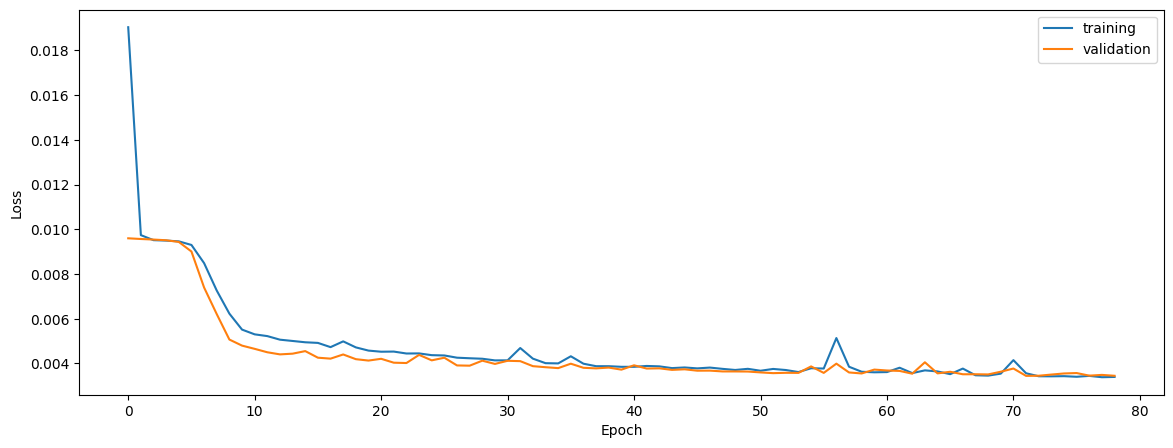

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7994501821511192
0.7998348502404136
0.7724700208762034


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7994501821511192
0.7998348502404136
0.7724700208762034


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.793604042509464
0.7951655534963481
0.7763175227569302


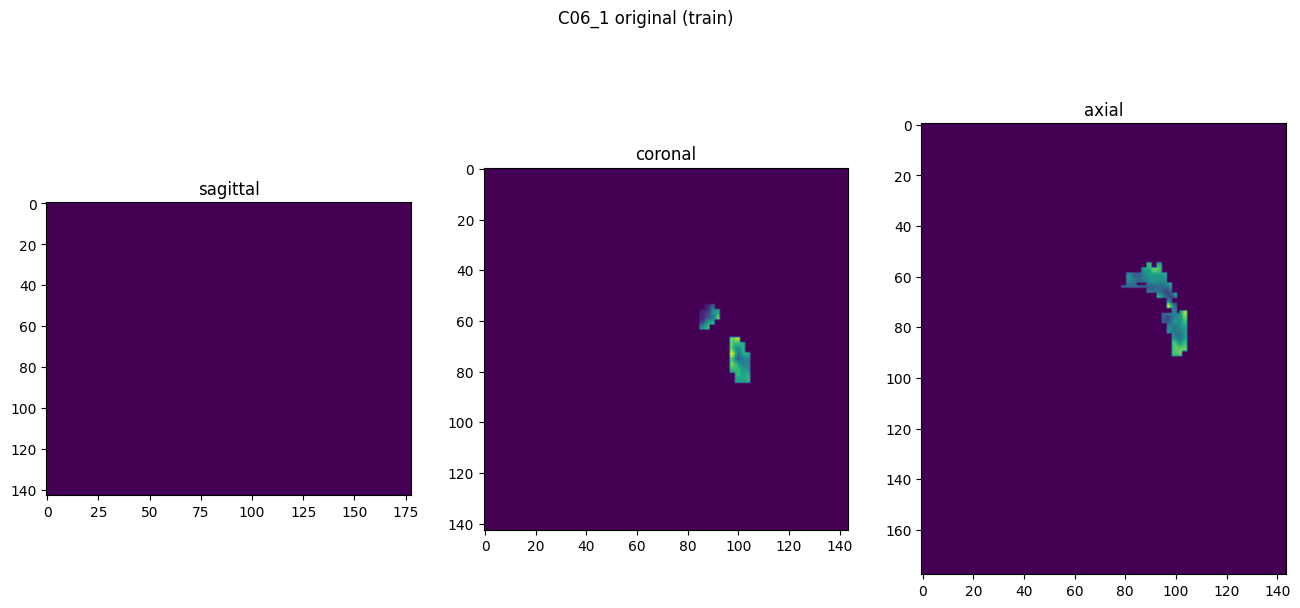

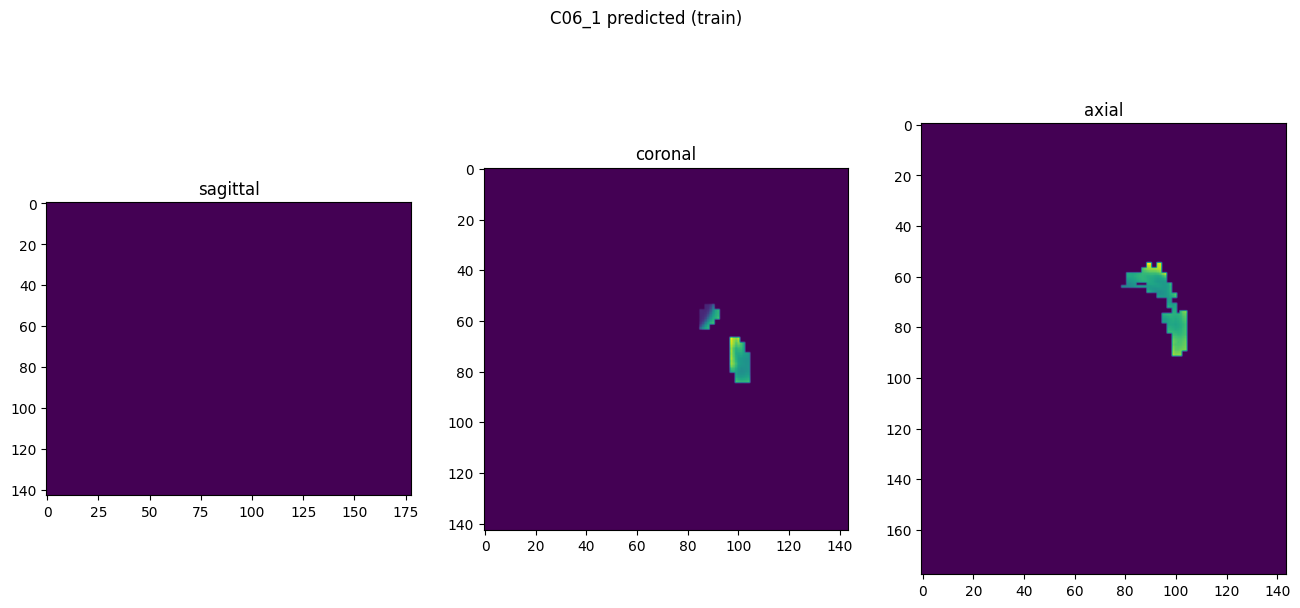

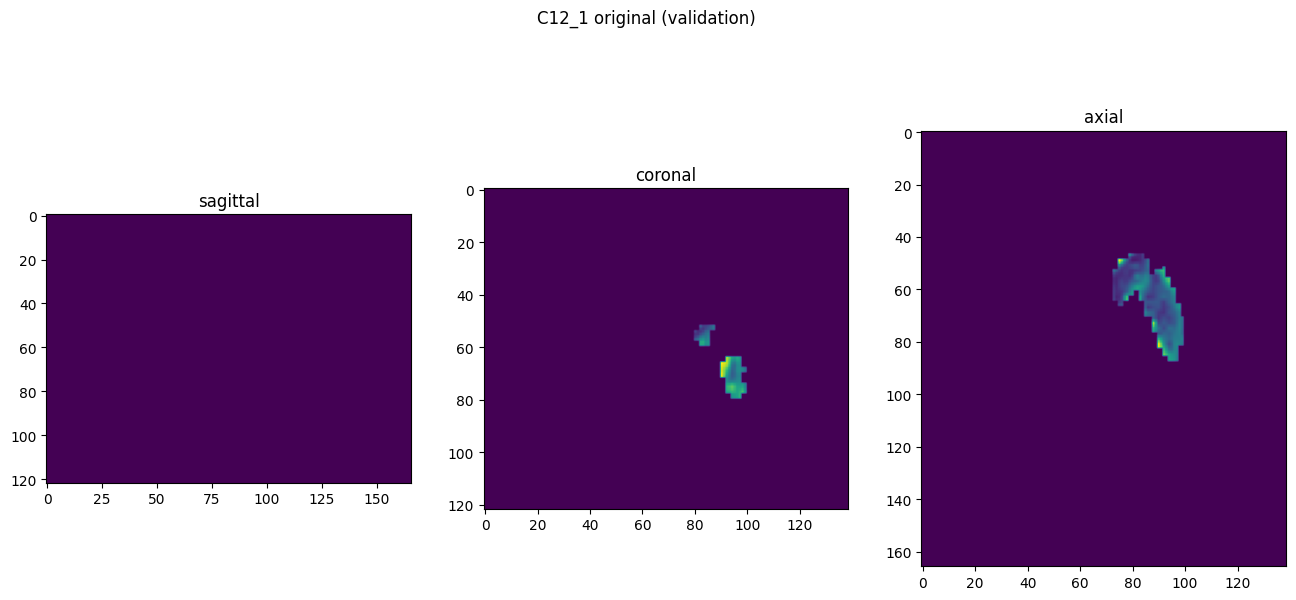

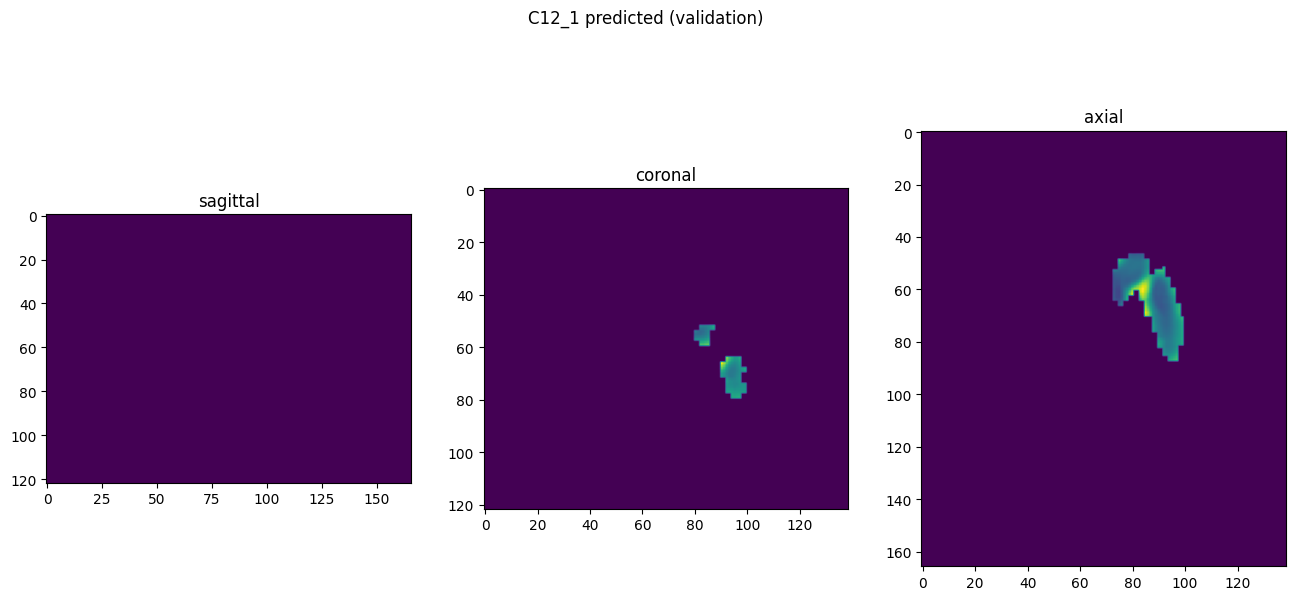

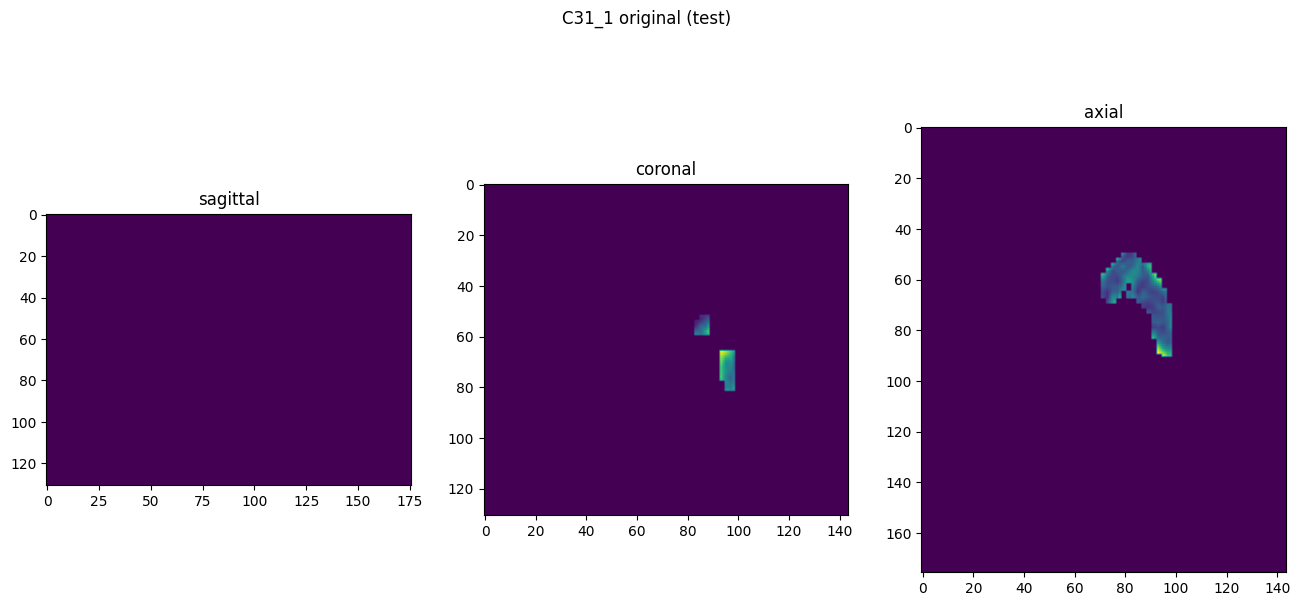

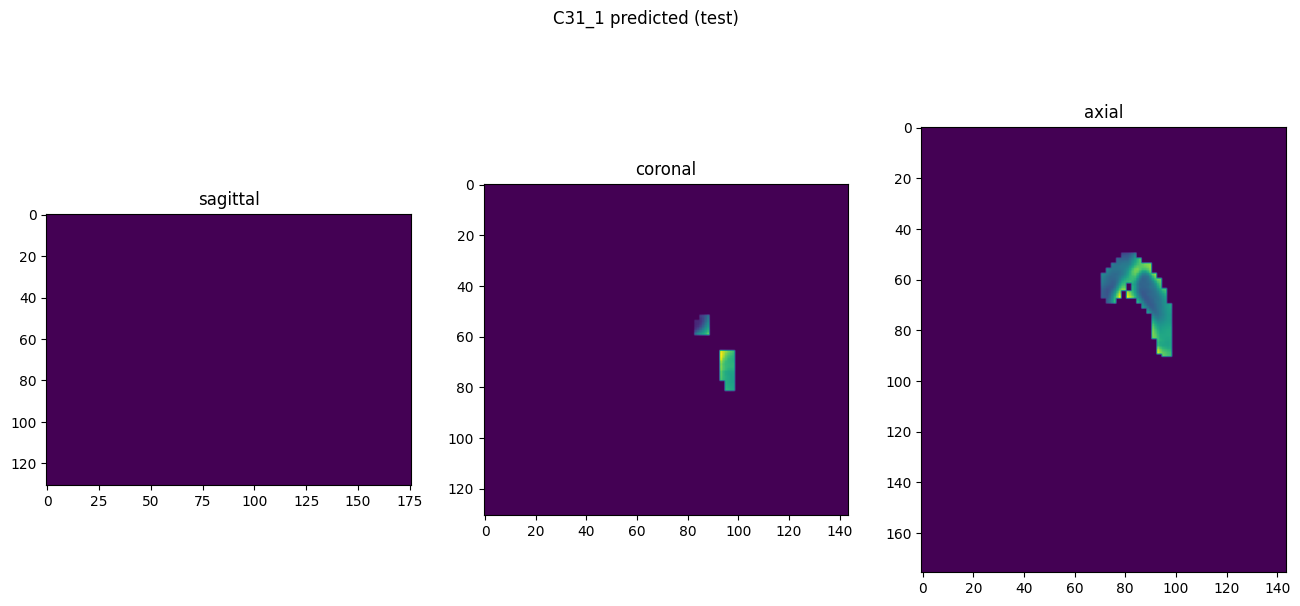

In [10]:
showResults(model, gen, threshold=None, background=False)